In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import InputLayer, Bidirectional, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

import time

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Indian_Extent = pd.read_excel(filepath, sheet_name='Indian-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Indian_Extent)
fp.date_time(Indian_Extent)

,Extent,Date
0,376618.799,1979-01-01
1,211788.726,1979-02-01
2,262868.141,1979-03-01
3,698377.304,1979-04-01
4,1252407.727,1979-05-01
...,...,...
533,1520776.003,2023-06-01
534,2076164.165,2023-07-01
535,2731799.027,2023-08-01
536,3179384.692,2023-09-01


In [5]:
scaler = MinMaxScaler()
Indian_Extent['Extent'] = scaler.fit_transform(Indian_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 7
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Indian_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((520, 12, 1), (520,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(Bidirectional(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0))))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Indian_model_LT7/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 38s 502ms/step - loss: 0.2310 - root_mean_squared_error: 0.4806 - val_loss: 0.1522 - val_root_mean_squared_error: 0.3901
Epoch 2/50
53/53 [==============================] - 25s 479ms/step - loss: 0.1012 - root_mean_squared_error: 0.3181 - val_loss: 0.0753 - val_root_mean_squared_error: 0.2743
Epoch 3/50
53/53 [==============================] - 25s 475ms/step - loss: 0.0811 - root_mean_squared_error: 0.2848 - val_loss: 0.0677 - val_root_mean_squared_error: 0.2601
Epoch 4/50
53/53 [==============================] - 25s 480ms/step - loss: 0.0698 - root_mean_squared_error: 0.2642 - val_loss: 0.0563 - val_root_mean_squared_error: 0.2372
Epoch 5/50
53/53 [==============================] - 26s 495ms/step - loss: 0.0567 - root_mean_squared_error: 0.2380 - val_loss: 0.0421 - val_root_mean_squared_error: 0.2053
Epoch 6/50
53/53 [==============================] - 27s 510ms/step - loss: 0.0360 - root_mean_squared_error: 0.1896 - val_loss: 0.0238 

Epoch 31/50
53/53 [==============================] - 4s 73ms/step - loss: 0.0051 - root_mean_squared_error: 0.0712 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0480
Epoch 32/50
53/53 [==============================] - 4s 72ms/step - loss: 0.0049 - root_mean_squared_error: 0.0702 - val_loss: 0.0023 - val_root_mean_squared_error: 0.0477
Epoch 33/50
53/53 [==============================] - 26s 507ms/step - loss: 0.0044 - root_mean_squared_error: 0.0663 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0441
Epoch 34/50
53/53 [==============================] - 4s 71ms/step - loss: 0.0044 - root_mean_squared_error: 0.0660 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0582
Epoch 35/50
53/53 [==============================] - 4s 72ms/step - loss: 0.0046 - root_mean_squared_error: 0.0679 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0585
Epoch 36/50
53/53 [==============================] - 4s 70ms/step - loss: 0.0040 - root_mean_squared_error: 0.0630 - val_loss: 0.0021 - va

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

13.025031526883444 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

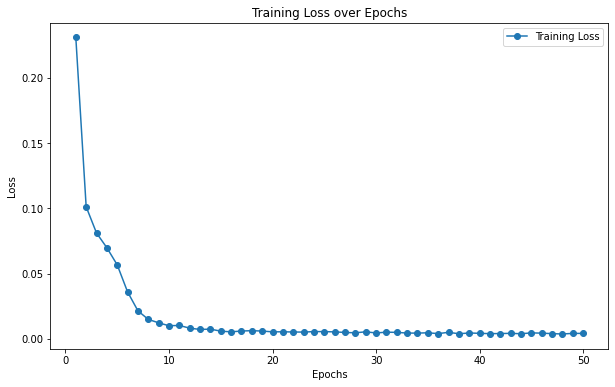

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

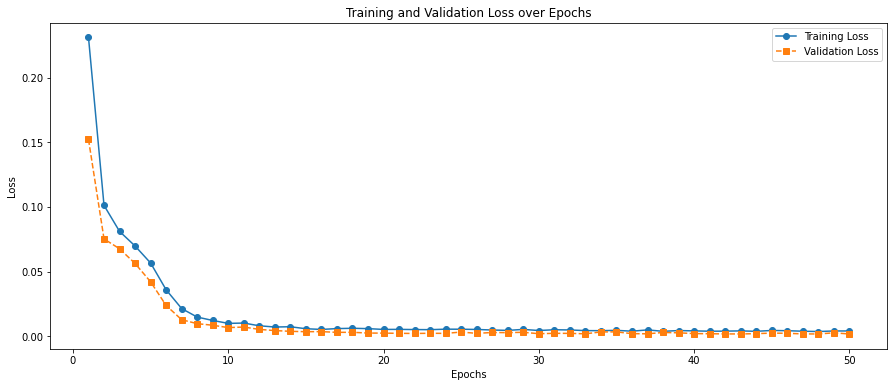

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Indian_model_LT7/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 2s 34ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.05722549244657014
MAE : 0.04924556338796171


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,2.987728e+06,2526913.818
1,1.436817e+06,1128752.378
2,3.801852e+05,522831.371
3,9.497439e+04,346601.304
4,1.300948e+05,444914.605
5,4.391694e+05,827036.916
6,1.077598e+06,1142021.216
7,1.823931e+06,1885693.654
8,2.442345e+06,2542569.663
9,2.953607e+06,3107373.845


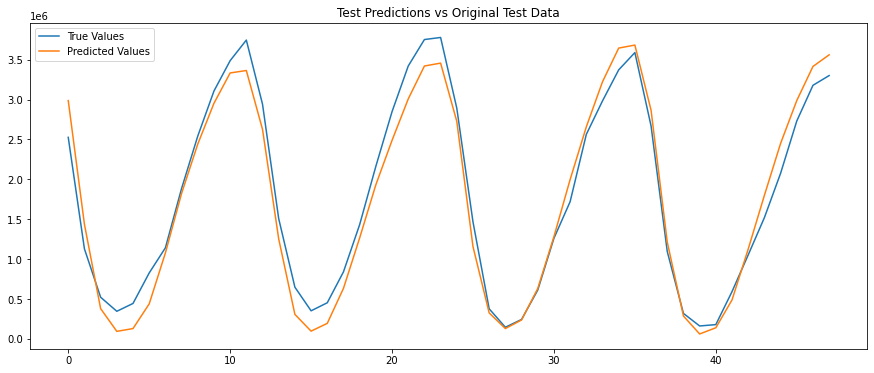

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 1s 37ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

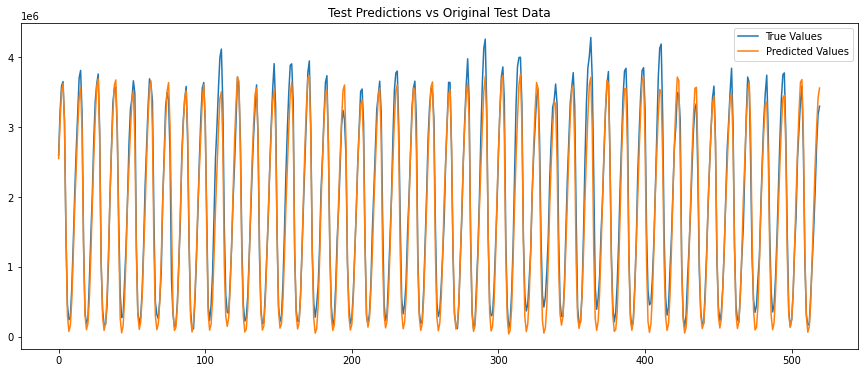

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()